In [41]:
import numpy as np
import pandas as pd
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer,StandardScaler,MinMaxScaler
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml import Pipeline

from pyspark.ml.clustering import KMeans,KMeansModel

sqlContext = SQLContext(sc)
df = sqlContext.read.csv("D:\\bigdata\\spark\\testdata\\catalogues_sample.csv", header=True, inferSchema=True)
#df.show()
#df.printSchema()

countryidx = StringIndexer(inputCol="Supplier Country", outputCol="country_idx")
countryidx_enc = OneHotEncoder(inputCol="country_idx", outputCol="country_idx_enc")

company_idx = StringIndexer(inputCol="Manufactured_Company", outputCol="company_idx")
company_idx_enc = OneHotEncoder(inputCol="company_idx", outputCol="company_idx_enc")

Spec_5_idx = StringIndexer(inputCol="Spec_5", outputCol="Spec_5_idx")
Spec_3_idx = StringIndexer(inputCol="Spec_3", outputCol="Spec_3_idx")

df.printSchema()

cols=["country_idx_enc","Delivery_in_days","company_idx_enc","Year_of_Mfg","Expiry_Year","Spec_1","Spec_2","Spec_3_idx","Spec_4","Spec_5_idx","Price"]

assembler = VectorAssembler(inputCols=cols,outputCol="features")

scaller = MinMaxScaler().setMin(0).setMax(1).setInputCol("features").setOutputCol("normalizedFeatures")


cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("normalizedFeatures")
    pipeline = Pipeline(stages=[countryidx,countryidx_enc,company_idx,company_idx_enc,Spec_3_idx,Spec_5_idx, assembler,scaller, kmeans])                      
    model = pipeline.fit(df)
    predictions = model.transform(df)
    cost[k] = model.stages[-1].computeCost(predictions)
    print(cost[k])


root
 |-- SNo: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Supplier Name: string (nullable = true)
 |-- Supplier Country: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Sub-Category: string (nullable = true)
 |-- Delivery_in_days: integer (nullable = true)
 |-- Manufactured_Company: string (nullable = true)
 |-- Year_of_Mfg: integer (nullable = true)
 |-- Expiry_Year: integer (nullable = true)
 |-- Spec_1: integer (nullable = true)
 |-- Spec_2: integer (nullable = true)
 |-- Spec_3: string (nullable = true)
 |-- Spec_4: double (nullable = true)
 |-- Spec_5: string (nullable = true)
 |-- Price: integer (nullable = true)
 |-- Currency: string (nullable = true)

31.94496296296299
22.448148148148178
19.67921296296297
18.04559082892417
14.359557539682534
14.701802910052923
11.48578703703706
9.290416666666692
9.928555555555558
8.550416666666656
6.640162037037038
5.931828703703704
4.936851851851843
5.130361111111114
3.789768518518517
3.28629629629

Text(0,0.5,'cost')

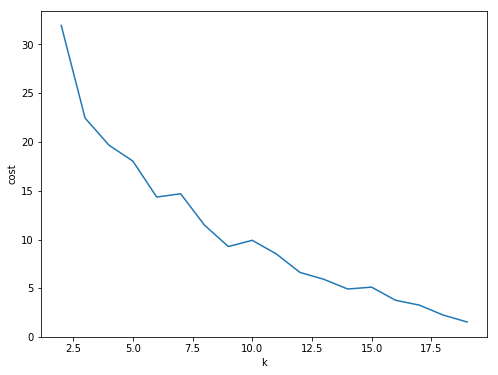

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets.samples_generator import make_blobs

fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [43]:
k = 6
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("normalizedFeatures")
pipeline = Pipeline(stages=[countryidx,countryidx_enc,company_idx,company_idx_enc,Spec_3_idx,Spec_5_idx, assembler,scaller, kmeans])                      
model = pipeline.fit(df)
predictions = model.transform(df)
cost = model.stages[-1].computeCost(predictions)
print(cost)
centers = model.stages[-1].clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

14.359557539682534
Cluster Centers: 
[1.         0.         0.4        1.         1.         0.2
 0.2        0.5        0.5        0.5        0.44666667]
[0.         1.         0.66666667 0.         0.         0.
 0.         0.5        0.5        0.5        0.16666667]
[0.   1.   1.   1.   1.   0.5  0.5  0.5  0.5  0.5  0.55]
[1.         0.         0.85714286 1.         1.         0.71428571
 0.71428571 0.5        0.5        0.5        0.67857143]
[1.         0.         0.66666667 0.         0.         0.
 0.         0.5        0.5        0.5        0.25      ]
[0.         1.         0.         1.         1.         0.5
 0.5        0.5        0.5        0.5        0.35416667]


In [54]:
transformed = predictions.select('SNo', 'prediction')
rows = transformed.collect()
df_pred = sqlContext.createDataFrame(rows)
df_pred = df_pred.join(df, 'SNo')
df_pred.show()








+---+----------+-------------+-------------+----------------+--------+------------+----------------+--------------------+-----------+-----------+------+------+------+------+-------+-----+--------+
|SNo|prediction|         Name|Supplier Name|Supplier Country|Category|Sub-Category|Delivery_in_days|Manufactured_Company|Year_of_Mfg|Expiry_Year|Spec_1|Spec_2|Spec_3|Spec_4| Spec_5|Price|Currency|
+---+----------+-------------+-------------+----------------+--------+------------+----------------+--------------------+-----------+-----------+------+------+------+------+-------+-----+--------+
|  1|         5|Lenevo Laptop|            A|           India|Computer|      Laptop|               5|                 IBM|       2018|       2022|     8|   500|   i-5|   3.1|Windows|40000|     INR|
|  2|         1|Lenevo Laptop|            A|           India|Computer|      Laptop|               5|                 IBM|       2017|       2021|     8|   500|   i-5|   3.1|Windows|30000|     INR|
|  3|         5

In [75]:
df_pred.filter(df_pred.prediction == 3).show()

+---+----------+-------------+-------------+----------------+--------+------------+----------------+--------------------+-----------+-----------+------+------+------+------+-------+-----+--------+
|SNo|prediction|         Name|Supplier Name|Supplier Country|Category|Sub-Category|Delivery_in_days|Manufactured_Company|Year_of_Mfg|Expiry_Year|Spec_1|Spec_2|Spec_3|Spec_4| Spec_5|Price|Currency|
+---+----------+-------------+-------------+----------------+--------+------------+----------------+--------------------+-----------+-----------+------+------+------+------+-------+-----+--------+
| 19|         3|Lenevo Laptop|            B|             USA|Computer|      Laptop|               3|                 IBM|       2018|       2022|    16|  1000|   i-5|   3.1|Windows|65000|     INR|
| 22|         3|    HP Laptop|            B|             USA|Computer|      Laptop|               3|                  HP|       2018|       2022|    16|   500|   i-5|   3.1|Windows|65000|     INR|
| 23|         3

d:\users\245-0117\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


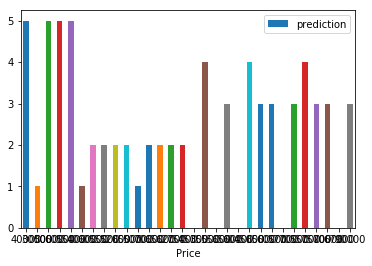

In [58]:
pddf_pred = df_pred.toPandas().set_index('SNo')
pddf_pred.head()

y = pddf_pred['prediction']
X = pddf_pred.ix[:, 'Supplier Name':]

pddf_pred.plot.bar(x='Price', y='prediction', rot=0)


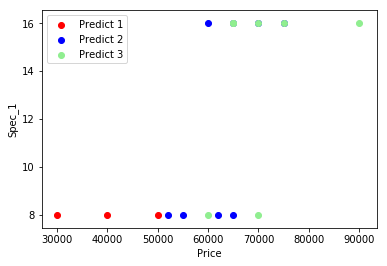

In [59]:
plt.scatter(X[y==1]['Price'] ,X[y==1]['Spec_1'],label='Predict 1', c='red')
plt.scatter(X[y==2]['Price'] ,X[y==2]['Spec_1'],label='Predict 2', c='blue')
plt.scatter(X[y==3]['Price'], X[y==3]['Spec_1'], label='Predict 3', c='lightgreen')


# Prettify the graph
plt.legend()
plt.xlabel('Price')
plt.ylabel('Spec_1')

# display
plt.show()

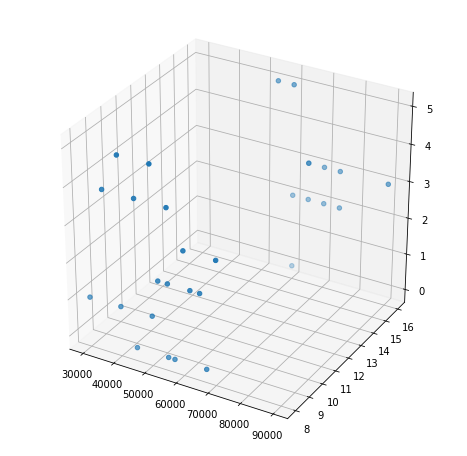

In [61]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X['Price'], X['Spec_1'], y)


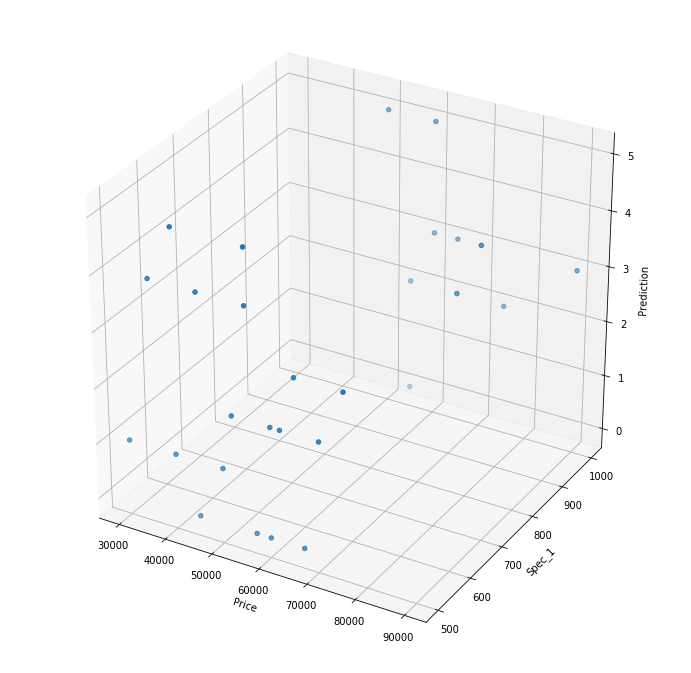

In [70]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X['Price'], X['Spec_2'], y)
ax.set_xlabel('Price')
ax.set_ylabel('Spec_1')
ax.set_zlabel('Prediction')
plt.show()

